CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
# TODO: Enter your code here
    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, no_labels),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset
# TODO: Enter your code here
df = pd.read_csv("audio_gtzan.csv")
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
# Drop non-feature columns
columns_to_drop = ['filename', 'label']

# Split dataset (70:30)
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, 0.3, 42)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# print(X_train.head())
# Note that 0 is for blues, 1 is for metal

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
# TODO: Enter your code here
# Define Pytorch Dataset
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)  # Ensure y is 2D

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create data loaders
train_dataset = AudioDataset(X_train_scaled, y_train)
test_dataset = AudioDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

2. Next, define the model, optimizer and loss function.

In [5]:
# TODO: Enter your code here
# print(X_train.columns)
input_dim = len(list(X_train.head()))
model = MLP(input_dim, 128, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from common_utils import EarlyStopper

# TODO: Enter your code here
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct_train = 0, 0
    size = len(dataloader.dataset)

    for X_batch, y_batch in dataloader:
        # Forward pass
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        train_loss += loss.item()
        predicted_train = (outputs > 0.5).float()  # Binary classification threshold
        correct_train += (predicted_train == y_batch).sum().item()

    # Calculate average loss and accuracy for the epoch
    train_loss /= len(dataloader)  # Average loss per batch
    train_accuracy = correct_train / size  # Accuracy for the epoch

    return train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    test_loss, correct_test = 0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

            # Accumulate loss and correct predictions
            test_loss += loss.item()
            predicted_test = (outputs > 0.5).float()  # Binary classification threshold
            correct_test += (predicted_test == y_batch).sum().item()

    # Calculate average loss and accuracy for the epoch
    test_loss /= len(dataloader)  # Average loss per batch
    test_accuracy = correct_test / size  # Accuracy for the epoch

    return test_loss, test_accuracy


# Early stopping
early_stopper = EarlyStopper(patience=3, min_delta=0)

# Training loop
epochs = 100
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    # Train for one epoch
    train_loss, train_accuracy = train_loop(
        train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Early stopping check
    if early_stopper.early_stop(test_loss):
        print("Early stopping triggered.")
        break

Epoch 1/100: Train Loss: 0.6091, Train Acc: 0.7786, Test Loss: 0.4803, Test Acc: 0.8200
Epoch 2/100: Train Loss: 0.3738, Train Acc: 0.8421, Test Loss: 0.3326, Test Acc: 0.8733
Epoch 3/100: Train Loss: 0.2575, Train Acc: 0.9000, Test Loss: 0.2429, Test Acc: 0.9033
Epoch 4/100: Train Loss: 0.1769, Train Acc: 0.9307, Test Loss: 0.1991, Test Acc: 0.9200
Epoch 5/100: Train Loss: 0.1269, Train Acc: 0.9564, Test Loss: 0.1935, Test Acc: 0.9317
Epoch 6/100: Train Loss: 0.0947, Train Acc: 0.9679, Test Loss: 0.1618, Test Acc: 0.9400
Epoch 7/100: Train Loss: 0.0778, Train Acc: 0.9736, Test Loss: 0.1471, Test Acc: 0.9483
Epoch 8/100: Train Loss: 0.0603, Train Acc: 0.9800, Test Loss: 0.1420, Test Acc: 0.9533
Epoch 9/100: Train Loss: 0.0491, Train Acc: 0.9864, Test Loss: 0.1255, Test Acc: 0.9567
Epoch 10/100: Train Loss: 0.0486, Train Acc: 0.9850, Test Loss: 0.1411, Test Acc: 0.9600
Epoch 11/100: Train Loss: 0.0372, Train Acc: 0.9871, Test Loss: 0.1229, Test Acc: 0.9617
Epoch 12/100: Train Loss: 0.02

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

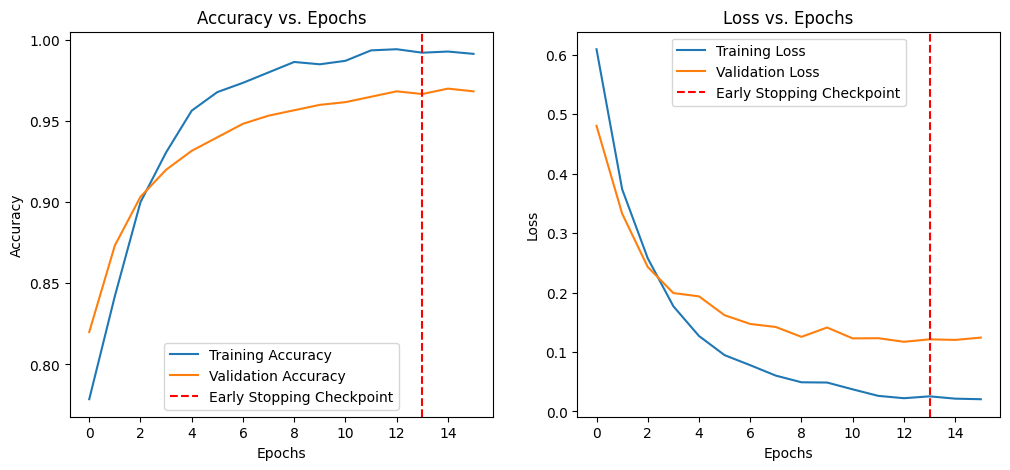

In [7]:
# TODO: Enter your code here
# Plot training and test accuracies
plt.figure(figsize=(12, 5))

# Plot accuracy on the left (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Validation Accuracy")
minposs = test_losses.index(min(test_losses)) + 1  # Epoch where early stopping occurred
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

# Plot training and test losses on the right (subplot 2)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
minposs = test_losses.index(min(test_losses)) + 1  # Epoch where early stopping occurred
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

plt.show()

\# TODO: \
The model achieves a high training and testing accuracy, indicating good performance on both training and testing dataset.\
The early stopping mechanism helped prevent further overfitting by halting training when the test loss stops improving significantly, around Epoch 13.


Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [8]:
# TODO: Enter your code here
from common_utils import MLP

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [9]:
# TODO: Enter your code here
# Define dictionary to store datasets for different batch sizes
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}


def prepare_folds(X, Y, batch_sizes, no_folds=5):
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        for train_idx, val_idx in kf.split(X):
            scaler = preprocessing.StandardScaler()
            X_train_scaled = scaler.fit_transform(X[train_idx])
            X_val_scaled = scaler.transform(X[val_idx])

            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(Y[train_idx])
            y_val_dict[batch_size].append(Y[val_idx])


# Convert DataFrame to NumPy arrays
df = df.drop('filename', axis=1)  # Drop unnecessary columns
Y = df['label'].to_numpy()
X = df.drop('label', axis=1).to_numpy()

batch_sizes = [32, 64, 128, 256]
prepare_folds(X, Y, batch_sizes)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [10]:
# TODO: Enter your code here
def train_exp(batch_sizes, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for batch_size in batch_sizes:
        accuracies = []
        epoch_times = []

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[batch_size][fold]
            y_train = y_train_dict[batch_size][fold]
            x_val = X_val_scaled_dict[batch_size][fold]
            y_val = y_val_dict[batch_size][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(
                y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(
                    x_train_tensor, y_train_tensor),
                batch_size=batch_size,
                shuffle=True
            )

            model = MLP(no_features=x_train.shape[1], no_hidden= 128, no_labels= 1)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(no_epochs):
                model.train()
                start_time = time.time()

                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                end_time = time.time()
                last_epoch_time = end_time - start_time  # Track last epoch time

            # Evaluate model
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_val_tensor)
                preds = (test_outputs > 0.5).float()
                accuracy = (preds == y_val_tensor).sum().item() / \
                    len(y_val_tensor)

            accuracies.append(accuracy)
            epoch_times.append(last_epoch_time)

        # Store mean performance
        results[batch_size] = {
            "mean_accuracy": np.mean(accuracies),
            "mean_time": np.mean(epoch_times)
        }

    return results


# Run training experiment
results = train_exp(batch_sizes)

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

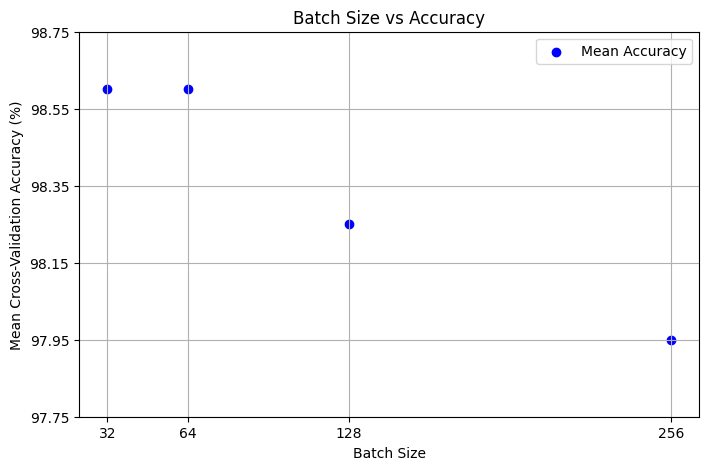

In [11]:
# TODO: Enter your code here
# Extract data for plotting
batch_sizes_list = list(results.keys())
mean_accuracies = [results[bs]["mean_accuracy"] * 100 for bs in batch_sizes_list]  # Convert to %
mean_times = [results[bs]["mean_time"] for bs in batch_sizes_list]

# Plot accuracies
plt.figure(figsize=(8, 5))
plt.scatter(batch_sizes_list, mean_accuracies, color='blue', label="Mean Accuracy")

# Format x and y labels
plt.xlabel("Batch Size")
plt.xticks(batch_sizes_list)  # ✅ Ensure x-axis only shows 32, 64, 128, 256
plt.ylabel("Mean Cross-Validation Accuracy (%)")  # ✅ Convert accuracy to percentage
plt.yticks(np.arange(min(mean_accuracies) - 0.2, max(mean_accuracies) + 0.2, 0.2))  # Adjust tick intervals

plt.title("Batch Size vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [12]:
# TODO: Enter your code here
# Print training time table
print("\nTraining Time for Last Epoch:")
print(f"{'Batch Size':<10} {'Mean Time (s)':<15}")
for bs, time_taken in zip(batch_sizes_list, mean_times):
    print(f"{bs:<10} {time_taken:<15.5f}")

# Select the optimal batch size (highest accuracy with reasonable time)
optimal_batch_size = batch_sizes_list[np.argmax(mean_accuracies)]
print(f"\nOptimal batch size: {optimal_batch_size}")


Training Time for Last Epoch:
Batch Size Mean Time (s)  
32         0.10092        
64         0.05425        
128        0.03351        
256        0.02573        

Optimal batch size: 32


5. Select the optimal batch size and state a reason for your selection.

\# TODO:\
The optimal batch size would be 32 in our case, it has one of the highest accuracy despite having the longest Batch Size Mean Time compared to the other batch sizes. Batch size 64 is a good contender given it is roughly close to half the Mean Time of Batch size 32 but both are still reasonable time given below 0.1s.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [13]:
# TODO: Enter your code here
from common_utils import MLP
# Notes to marker, only in this portion did I realized that my MLP class has been hard coded (128x128 in Q1)
# But I am not sure if we are supposed to show that it is different only as we progress
# or are they supposed to all be the same since the start of this assignment.

# Define dictionary to store datasets for different neuron configurations
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}


def prepare_folds(X, Y, hidden_units, no_folds=5):
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    for neurons in hidden_units:
        X_train_scaled_dict[neurons] = []
        X_val_scaled_dict[neurons] = []
        y_train_dict[neurons] = []
        y_val_dict[neurons] = []

        for train_idx, val_idx in kf.split(X):
            scaler = preprocessing.StandardScaler()
            X_train_scaled = scaler.fit_transform(X[train_idx])
            X_val_scaled = scaler.transform(X[val_idx])

            X_train_scaled_dict[neurons].append(X_train_scaled)
            X_val_scaled_dict[neurons].append(X_val_scaled)
            y_train_dict[neurons].append(Y[train_idx])
            y_val_dict[neurons].append(Y[val_idx])


# Convert DataFrame to NumPy arrays
label_encoder = preprocessing.LabelEncoder()
df = pd.read_csv("audio_gtzan.csv")
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
df['label'] = label_encoder.fit_transform(df['label'])
# Drop non-feature columns
Y = df['label'].to_numpy()
df = df.drop('filename', axis=1)
X = df.drop('label', axis=1).to_numpy()

hidden_units = [64, 128, 256]
prepare_folds(X, Y, hidden_units)

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [14]:
# TODO: Enter your code here
def train_exp(hidden_units, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for neurons in hidden_units:
        accuracies = []

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[neurons][fold]
            y_train = y_train_dict[neurons][fold]
            x_val = X_val_scaled_dict[neurons][fold]
            y_val = y_val_dict[neurons][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(
                y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(
                    x_train_tensor, y_train_tensor),
                batch_size=32,  # Keep batch size fixed
                shuffle=True
            )

            model = MLP(no_features=x_train.shape[1], no_hidden= neurons, no_labels= 1)  # 3 hidden layers
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(no_epochs):
                model.train()
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # Evaluate model
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_val_tensor)
                preds = (test_outputs > 0.5).float()
                accuracy = (preds == y_val_tensor).sum().item() / \
                    len(y_val_tensor)

            accuracies.append(accuracy)

        # Store mean accuracy
        results[neurons] = np.mean(accuracies)

    return results


# Run experiment for different hidden-layer neurons
results = train_exp(hidden_units)

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

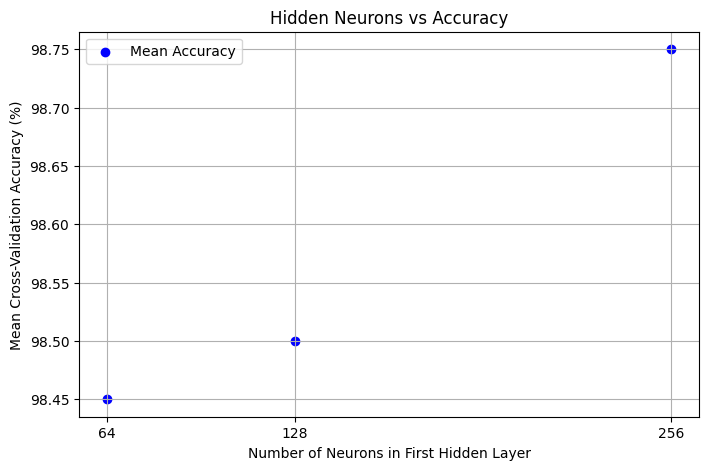

In [15]:
# TODO: Enter your code here
# Extract data for plotting
neuron_list = list(results.keys())
mean_accuracies = [results[n] * 100 for n in neuron_list]  # Convert to %

# Plot accuracies
plt.figure(figsize=(8, 5))
plt.scatter(neuron_list, mean_accuracies, color='blue', label="Mean Accuracy")

# Format x and y labels
plt.xlabel("Number of Neurons in First Hidden Layer")
plt.xticks(neuron_list)  # ✅ Ensure x-axis only shows 64, 128, 256
plt.ylabel("Mean Cross-Validation Accuracy (%)")  # ✅ Convert accuracy to percentage

plt.title("Hidden Neurons vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()


> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [16]:
# TODO: Enter your code here
# Select the optimal number of neurons (highest accuracy)
optimal_neurons = neuron_list[np.argmax(mean_accuracies)]
print(f"\nOptimal number of neurons: {optimal_neurons}")



Optimal number of neurons: 256


\# TODO: \<Enter your answer here\>

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

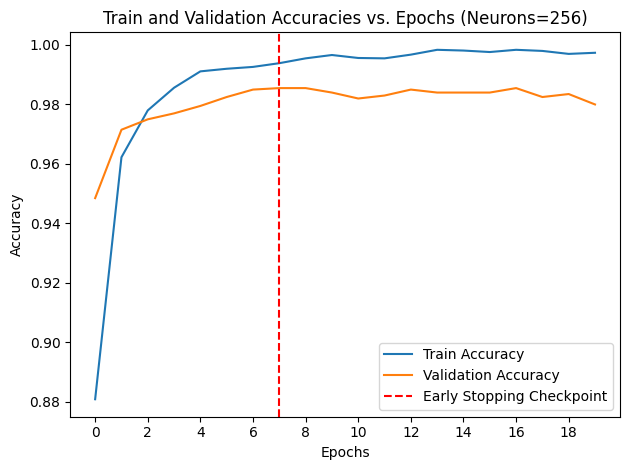

Model saved successfully!


In [17]:
# TODO: Enter your code here
def train_exp(hidden_units, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for neurons in hidden_units:
        accuracies = []
        train_accuracies_folds = []  # To store training accuracies for each fold
        val_accuracies_folds = []    # To store validation accuracies for each fold

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[neurons][fold]
            y_train = y_train_dict[neurons][fold]
            x_val = X_val_scaled_dict[neurons][fold]
            y_val = y_val_dict[neurons][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor),
                batch_size=32,
                shuffle=True
            )

            model = MLP(no_features=x_train.shape[1], no_hidden=neurons, no_labels=1)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Initialize lists to store accuracies for this fold
            train_accuracies = []
            val_accuracies = []

            # For each epoch, track accuracies
            for epoch in range(no_epochs):
                model.train()
                correct_train = 0
                total_train = 0
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                    # Calculate training accuracy
                    preds_train = (outputs > 0.5).float()
                    correct_train += (preds_train == batch_y).sum().item()
                    total_train += len(batch_y)

                train_accuracy = correct_train / total_train
                train_accuracies.append(train_accuracy)

                # Evaluate on validation set
                model.eval()
                with torch.no_grad():
                    val_outputs = model(x_val_tensor)
                    preds_val = (val_outputs > 0.5).float()
                    correct_val = (preds_val == y_val_tensor).sum().item()
                    val_accuracy = correct_val / len(y_val_tensor)
                    val_accuracies.append(val_accuracy)

            # Store accuracies for this fold
            train_accuracies_folds.append(train_accuracies)
            val_accuracies_folds.append(val_accuracies)

            # Store mean accuracy for this fold
            accuracies.append(np.mean(val_accuracies))

        # Store the average of accuracies for this configuration
        results[neurons] = np.mean(accuracies)

        # Plot the train and test accuracies for this configuration (256 neurons)
        if neurons == 256:
            # After training, save the model
            torch.save(model.state_dict(), "optimized_model.pth")
            # Average accuracies across folds for each epoch
            avg_train_accuracies = np.mean(train_accuracies_folds, axis=0)
            avg_val_accuracies = np.mean(val_accuracies_folds, axis=0)
            best_epoch = np.argmax(avg_val_accuracies) + 1  # +1 because epochs start from 1
            plt.plot(avg_train_accuracies, label='Train Accuracy')
            plt.plot(avg_val_accuracies, label='Validation Accuracy')
            plt.axvline(best_epoch - 1, linestyle='--', color='r', label='Early Stopping Checkpoint')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title(f'Train and Validation Accuracies vs. Epochs (Neurons={neurons})')
            plt.xticks(np.arange(0, no_epochs, 2))
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results

# Run experiment for different hidden-layer neurons
results = train_exp([256])  # Run only for the optimal number of neurons

print("Model saved successfully!")

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [18]:
# TODO: Enter your code here
from common_utils import MLP
from common_utils import extract_features

> Install and import shap

In [19]:
# TODO: Enter your code here
import shap

c:\Users\Alan Wong\Desktop\Assignment\2025_NNDL_IndivAssignment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [20]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [21]:
# TODO: Enter your code here
df = extract_features(filepath="audio_test.wav")
num_rows, num_columns = df.shape
size_row = num_rows
size_column = num_columns

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [22]:
# TODO: Enter your code here
df = df.drop('filename', axis=1)  # Drop unnecessary columns
test_data = df.to_numpy(dtype=np.float32)
print(test_data)
print("Test Data Shape:", test_data.shape)
feature_names = df.columns.tolist()


[[ 4.31877106e-01  8.00572261e-02  5.66040911e-02  2.92609882e-04
   1.19161975e+03  4.09576016e+04  1.72691748e+03  3.88313242e+04
   2.79422534e+03  3.66570625e+05  3.93690951e-02  1.35185444e-04
   1.55044254e-04  2.05747341e-03  5.84784022e-04  6.02687302e-04
   9.22851562e+01 -2.53927399e+02  1.48624060e+03  1.42315613e+02
   1.71351654e+02 -3.84771538e+00  8.95930939e+01  5.61431084e+01
   8.10451813e+01 -1.04636154e+01  6.45900421e+01  2.80343914e+01
   6.94090500e+01  4.58935887e-01  4.40883064e+01  1.46890049e+01
   4.78800926e+01 -9.87347126e+00  4.14087486e+01  1.00617485e+01
   2.83621826e+01 -5.29262924e+00  5.67159271e+01  3.31448054e+00
   5.88336143e+01 -1.88928471e+01  2.83292332e+01 -2.25425291e+00
   3.29645576e+01 -1.13571138e+01  2.59647522e+01 -3.74618149e+00
   5.66478539e+01 -6.39142513e+00  3.71675949e+01 -2.30341220e+00
   4.36759262e+01 -8.24770832e+00  3.05021420e+01 -1.37864904e+01
   4.69415436e+01]]
Test Data Shape: (1, 57)


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [23]:
# TODO: Enter your code here
# Convert to tensor
test_tensor = torch.tensor(test_data, dtype=torch.float32)
print("Test Tensor Shape:", test_tensor.shape)

# Load the optimized model
optimal_neurons = 256
optimal_batch_size = 32

model = MLP(no_features=test_data.shape[1], no_hidden=optimal_neurons, no_labels=1)
model.load_state_dict(torch.load("optimized_model.pth"))  # Load the pretrained model
model.eval()

# Perform model prediction
with torch.no_grad():
    output = model(test_tensor)

print("Raw Model Output:", output.numpy())  # Print raw predictions
# Apply threshold to obtain predicted label
pred_label = (output > 0.5).float()

print("Predicted Label:", pred_label.numpy())
print(pred_label)

Test Tensor Shape: torch.Size([1, 57])
Raw Model Output: [[1.]]
Predicted Label: [[1.]]
tensor([[1.]])


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [26]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

# Convert test data to numpy array if needed
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_np = X_test.to_numpy() if hasattr(X_test, "to_numpy") else X_test

# Predict on a single instance
# Evaluate predictions on multiple test samples
predictions = model(torch.tensor(X_test_np[:10], dtype=torch.float32)).detach().numpy()
print("Predictions for first 10 instances:", predictions)

print("Feature ranges for X_test_np:")
print(X_test_np.min(axis=0), X_test_np.max(axis=0))


# Ensure feature names match dataset features
assert len(feature_names) == X_test_np.shape[1], "Mismatch between feature names and dataset features."

# Verify model output shape
print("Model output shape for one instance:", model(torch.tensor(X_test_np[0], dtype=torch.float32).unsqueeze(0)).shape)

# Initialize DeepExplainer
explainer = shap.DeepExplainer(model, torch.tensor(X_test_np, dtype=torch.float32))
print("Explainer expected value:", explainer.expected_value)

# Compute SHAP values
shap_values = explainer.shap_values(torch.tensor(X_test_np, dtype=torch.float32))

# Debug shapes and values
print("Shape of shap_values[0]:", shap_values[0].shape)
print("SHAP values for first sample:", shap_values[0])

# Reshape SHAP values (flatten each entry)
shap_values_flattened = shap_values[0].flatten()

# Ensure X_test_np[0] is a 1D array
X_instance = X_test_np[0].flatten() if len(X_test_np[0].shape) > 1 else X_test_np[0]

# Visualize using force_plot
shap.initjs()
try:
    shap.force_plot(
        explainer.expected_value[0],  # Expected value for the model output
        shap_values_flattened,       # Flattened SHAP values for the first sample
        X_instance,                  # First sample from test data (1D array)
        feature_names=feature_names  # Feature names
    )
except Exception as e:
    print("Force plot failed:", e)

# # Try waterfall plot if force plot fails
# shap.waterfall_plot(
#     shap.Explanation(values=shap_values_flattened, base_values=explainer.expected_value[0], data=X_instance, feature_names=feature_names)
# )


Predictions for first 10 instances: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
Feature ranges for X_test_np:
[ 2.00699836e-01  4.05952630e-02  3.48709747e-02  7.04353215e-06
  5.26149156e+02  1.11021944e+04  9.14789429e+02  1.60856656e+03
  7.89274715e+02  3.32776265e+04  1.63499100e-02  3.47157202e-05
 -1.28342300e-02  7.31297000e-04 -8.38043700e-03  6.39527861e-05
  4.96920072e+01 -3.80979675e+02  3.25262756e+01  4.05199966e+01
  2.97100601e+01 -9.86467667e+01  3.27730827e+01  1.23662806e+01
  1.87043018e+01 -4.34195824e+01  1.75304298e+01 -1.12157955e+01
  1.30649452e+01 -4.00898056e+01  1.68204937e+01 -8.61330891e+00
  1.40347357e+01 -3.31076240e+01  1.38308277e+01 -1.28732224e+01
  1.23822823e+01 -3.53335342e+01  1.42934837e+01 -1.85721226e+01
  1.17742338e+01 -2.87692833e+01  1.20879965e+01 -1.83302479e+01
  1.24467850e+01 -2.50211277e+01  1.09057388e+01 -2.48471432e+01
  9.97559834e+00 -2.14625854e+01  9.42357826e+00 -1.77762089e+01
  1.04318104e+01 -2.06777191

c:\Users\Alan Wong\Desktop\Assignment\2025_NNDL_IndivAssignment\.venv\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Shape of shap_values[0]: (57, 1)
SHAP values for first sample: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


\# TODO: \<Enter your answer here\>